In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
from data_processing.preprocessing import *

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from utils.plotting import *
from model.cnn import *
from model.gru import *
from model.lstm import *
from model.unet import *
from model.transformer import *
from model.metrics import *

In [2]:
#import data
data = pd.read_csv("../gle.csv")
data.head()

,Date,Adj Close,Close,High,Low,Open,Volume,ma_close_5,ma_volume_5,ma_close_10,ma_volume_10,log_return
0,2010-01-04,28.579245,50.240002,50.240002,49.209999,49.450001,1825303.0,28.836935,2866634.8,28.838072,3177878.8,-0.006490
1,2010-01-05,28.394365,49.915001,50.779999,49.500000,50.049999,2649565.0,28.836935,2866634.8,28.838072,3177878.8,-0.006490
2,2010-01-06,28.397207,49.919998,50.380001,49.584999,50.299999,3437614.0,28.836935,2866634.8,28.838072,3177878.8,0.000100
3,2010-01-07,29.187920,51.310001,51.369999,49.500000,49.599998,2757126.0,28.836935,2866634.8,28.838072,3177878.8,0.027464
4,2010-01-08,29.625937,52.080002,52.509998,51.270000,51.549999,3663566.0,28.836935,2866634.8,28.838072,3177878.8,0.014895


In [3]:
features=['Adj Close', 'Close', 'Volume','log_return','ma_close_10','ma_volume_5']

In [4]:
gap = 400  # Gap between each subset

total_samples = len(data)
train_size = int(0.45 * total_samples)
test_size = int(0.15 * total_samples)
validation_size = int(0.15 * total_samples)

train,test,validation=data_splitting(data,train_size,test_size,validation_size,gap)

In [5]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Scaler for the target to inverse transform y_pred 
target = train[['Adj Close']]
scaler_target = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_target.fit_transform(target)

# Scaler for the training dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[features])
scaled_train = pd.DataFrame(scaled_train, columns=features)

# Applying the scaler of the training set onto test and validation set
scaled_test = scaler.transform(test[features])
scaled_test = pd.DataFrame(scaled_test, columns=features)

scaled_validation = scaler.transform(validation[features])
scaled_validation = pd.DataFrame(scaled_validation, columns=features)

In [6]:
timesteps = 30
X_train, y_train = create_sequences(scaled_train, target_column='Adj Close', timesteps=timesteps)
X_test, y_test = create_sequences(scaled_test, target_column='Adj Close', timesteps=timesteps)
X_validation, y_validation = create_sequences(scaled_validation, target_column='Adj Close', timesteps=timesteps)

<h2>Forecast Horizons</h2>

In [7]:
horizon = 20
X_train, y_train = create_multistep_sequences(scaled_train, target_column='Adj Close', timesteps=timesteps,forecast_horizon=horizon)
X_test, y_test = create_multistep_sequences(scaled_test, target_column='Adj Close', timesteps=timesteps,forecast_horizon=horizon)
X_validation, y_validation = create_multistep_sequences(scaled_validation, target_column='Adj Close', timesteps=timesteps,forecast_horizon=horizon)

In [8]:
# Build and train the LSTM model
model = build_deep_lstm_model((X_train.shape[1], X_train.shape[2])) # Input shape (timesteps, features)
model.summary()

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitors the validation loss
    patience=10,            # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores weights from the best epoch
)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 128)        │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 7, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        44,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,169 (485.04 KB)

 Trainable params: 123,529 (482.54 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.8221 - val_loss: 0.1588
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0793 - val_loss: 0.0817
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0580 - val_loss: 0.0623
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0480 - val_loss: 0.0696
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0415 - val_loss: 0.0430
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0372 - val_loss: 0.0395
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0335 - val_loss: 0.0381
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0315 - val_loss: 0.0320
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0294 - val_loss: 0.0236
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0298 - val_loss: 0.0204
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0257 - val_loss: 0.0266
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0264 - val_lo

In [9]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE: 2.6106
NSE: 0.7265


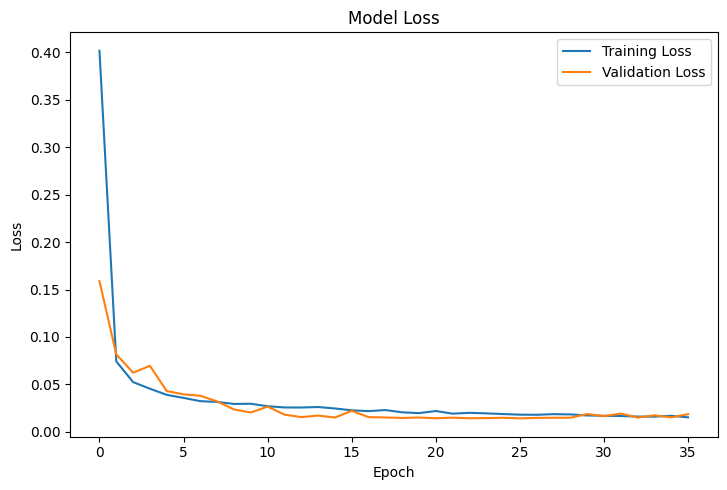

In [10]:
plot_learning_curves(history)

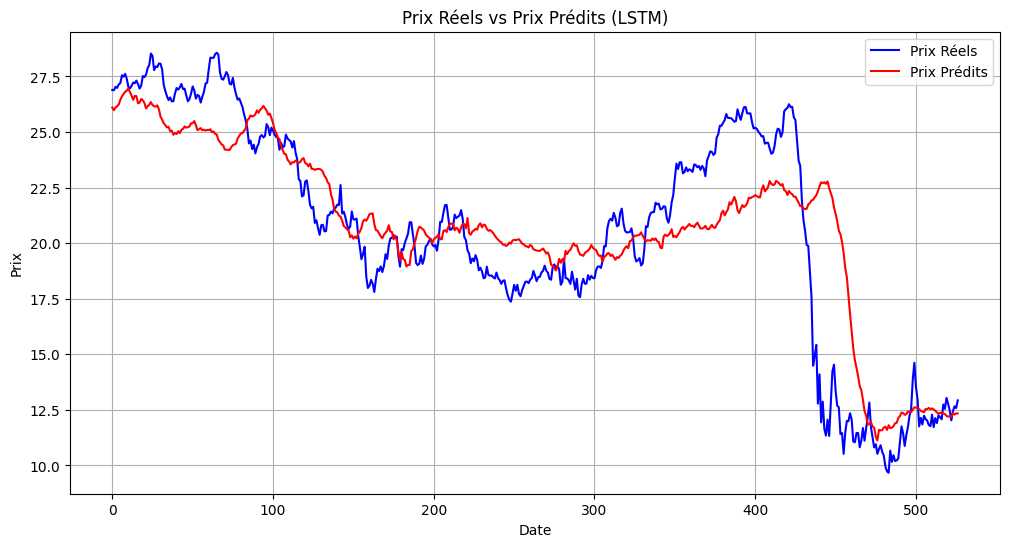

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (LSTM)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()


In [12]:
def persistence_model(y_actual, horizon):
    """
    Implements a persistence model.
    :param y_actual: Array of true values
    :param horizon: Forecast horizon
    :return: Array of predictions
    """
    y_pred = y_actual[:-horizon]
    return y_pred

# Example usage:
# True values for comparison
true_values = y_test[horizon:]  # Exclude first 'horizon' values
y_pred = persistence_model(y_test, horizon)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(true_values.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

RMSE: 2.7687
NSE: 0.6826


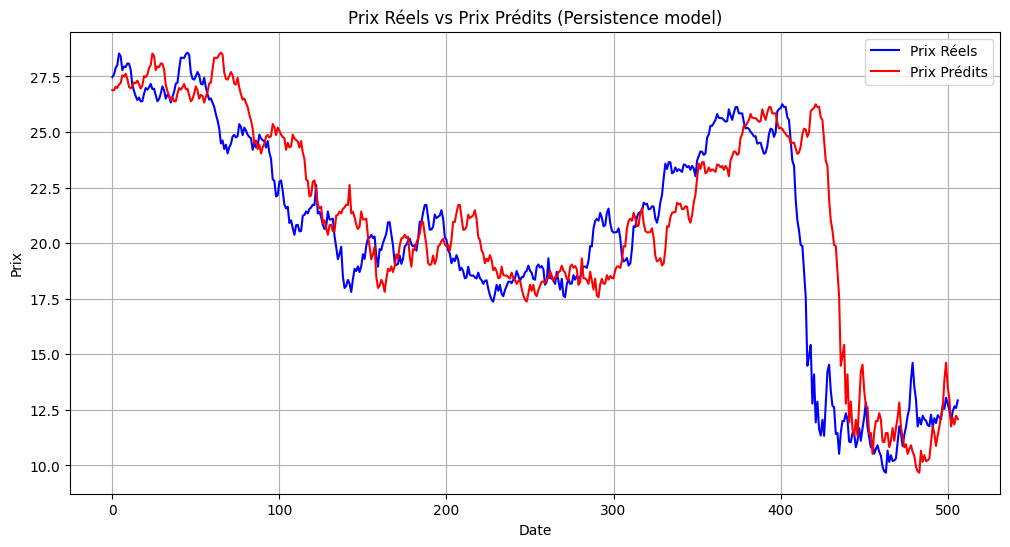

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (Persistence model)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()